It is to train a demo GAN

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from data_gen import get_simu_data
from models.gan_v2 import Generator, Discriminator

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict

# GAN

In [5]:
#%matplotlib inline
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
torch.set_default_dtype(torch.float64)
torch.set_default_tensor_type(torch.DoubleTensor)
plt.style.use(FIG_ROOT/"base.mplstyle")

Random Seed:  999


In [23]:
import logging
logger = logging.getLogger()
logger.handlers[0]

[]

In [6]:
def get_pdf_at_xx(Y1, Y2):
    pdf1 = ss.gaussian_kde(Y1)
    pdf2 = ss.gaussian_kde(Y2)
    l1, u1 = np.quantile(Y1, [0.01, 0.99])
    l2, u2 = np.quantile(Y2, [0.01, 0.99])
    xmin = min(l1, l2)
    xmax = max(u1, u2)
    xx = np.linspace(xmin, xmax, 100)
    p_pdf1 = pdf1(xx);
    p_pdf2 = pdf2(xx);
    return xx, p_pdf1, p_pdf2
def get_kl(Y1, Y2):
    xx, p1, p2 = get_pdf_at_xx(Y1, Y2)
    kl_div_12 = np.sum(np.where(p1 != 0, p1 * np.log(p1 / p2), 0))
    kl_div_21 = np.sum(np.where(p2 != 0, p2 * np.log(p2 / p1), 0))
    return kl_div_12, kl_div_21

## Parameters

In [7]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Size of z latent vector (i.e. size of generator input)
nz = 10

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5


device="cpu"
rho = 0.9
is_homo = True
n, d = 500, 100
ntest = 1000

save_dir = RES_ROOT/"demo2_d100"
if not save_dir.exists():
    save_dir.mkdir()

## Data loader

In [8]:
from torch.utils.data import Dataset, DataLoader

class MyDataSet(Dataset):
    def __init__(self, Y, X):
        
        assert Y.shape[0] == X.shape[0], "X and Y should have same length"
        self.Y = Y
        self.X = X
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        y = self.Y[idx]
        x = self.X[idx]
        return x, y

In [9]:
data = get_simu_data(n, d, rho=0.9, is_homo=True, is_condition=False);
datatest = get_simu_data(ntest, d, rho=0.9, is_homo=True, is_condition=False);

training_data = MyDataSet(Y=data.Y1, X=data.X)
testing_data = MyDataSet(Y=datatest.Y1, X=datatest.X)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

## Two nets

In [10]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Loss aod optimizer

In [11]:
netG = Generator(d, nz);
netD = Discriminator(d);
netG.apply(weights_init);
netD.apply(weights_init);

In [12]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()
#criterion = nn.MSELoss()

# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0.1

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999));


In [13]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
test_errs = []
iters = 0

print("Starting Training Loop...")
# For each epoch
netG.train()
netD.train()
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        X, realY = data
        realY = realY.unsqueeze(-1)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        b_size = realY.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float64, device=device)
        # Forward pass real batch through D
        output = netD(X, realY).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = netG(X, noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(X, fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(X, fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if (iters+1) % 50 == 0:
            tX = torch.tensor(datatest.X)
            tZ = torch.randn(ntest, nz);
            
            netG.eval()
            with torch.no_grad():
                tY_hat = netG(tX, tZ).detach().numpy().reshape(-1);
                test_err = np.sqrt(np.mean((tY_hat - datatest.Y1)**2))
                v, _ = ss.pearsonr(datatest.Y1, tY_hat)
                
                datatest_con = get_simu_data(ntest, d, rho=0.9, is_homo=True, is_condition=True);
                tX_con = torch.tensor(datatest_con.X)
                tY_hat_con = netG(tX_con, tZ).detach().numpy().reshape(-1);
                #kl1, kl2 = get_kl(tY_hat_con, datatest_con.Y1)

            print(f"[{epoch+1}/{num_epochs}][{i:>3}/{len(train_dataloader)}], "
                  f"Loss_D: {errD.item():.3f} Loss_G: {errG.item():.3f}, "
                  f"D(x): {D_x:.3f} D(G(z)): {D_G_z1:.3f}/ {D_G_z2:.3f}, "
                  f"Test error: {test_err:.3f} and {v:.3f}, ")
                  #f"KL: {kl1:.3f} and {kl2:.3f}")
            test_errs.append(test_err)
            netG.train()
            
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())


        iters += 1
    if (epoch+1) % 100 == 0:
        torch.save(netG.state_dict(), save_dir/f"gan_v1_demo_G_epoch{epoch+1}.pth")
        torch.save(netD.state_dict(), save_dir/f"gan_v1_demo_D_epoch{epoch+1}.pth")

Starting Training Loop...
[4/1000][  1/16], Loss_D: 1.387 Loss_G: 0.695, D(x): 0.500 D(G(z)): 0.501/ 0.499, Test error: 2.586 and 0.330, 
[7/1000][  3/16], Loss_D: 1.388 Loss_G: 0.704, D(x): 0.497 D(G(z)): 0.498/ 0.494, Test error: 2.798 and 0.638, 
[10/1000][  5/16], Loss_D: 1.386 Loss_G: 0.695, D(x): 0.500 D(G(z)): 0.500/ 0.499, Test error: 1.905 and 0.569, 
[13/1000][  7/16], Loss_D: 1.388 Loss_G: 0.686, D(x): 0.498 D(G(z)): 0.499/ 0.505, Test error: 1.755 and 0.584, 
[16/1000][  9/16], Loss_D: 1.387 Loss_G: 0.677, D(x): 0.505 D(G(z)): 0.505/ 0.511, Test error: 2.495 and -0.090, 
[19/1000][ 11/16], Loss_D: 1.386 Loss_G: 0.703, D(x): 0.495 D(G(z)): 0.495/ 0.494, Test error: 2.727 and 0.451, 
[22/1000][ 13/16], Loss_D: 1.386 Loss_G: 0.691, D(x): 0.502 D(G(z)): 0.502/ 0.501, Test error: 2.218 and 0.555, 
[25/1000][ 15/16], Loss_D: 1.390 Loss_G: 0.691, D(x): 0.490 D(G(z)): 0.491/ 0.502, Test error: 3.535 and 0.102, 
[29/1000][  1/16], Loss_D: 1.386 Loss_G: 0.698, D(x): 0.498 D(G(z)): 0.

In [14]:
def moving_average(data, window_size):
    """
    Calculates the moving average of the given data using NumPy.

    :param data: A NumPy array or a list of numerical values.
    :param window_size: The size of the moving window. It must be a positive integer.
    :return: A NumPy array containing the moving averages.
    """
    if window_size <= 0:
        raise ValueError("Window size must be a positive integer")

    if len(data) < window_size:
        raise ValueError("Data length must be larger than or equal to the window size")

    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)



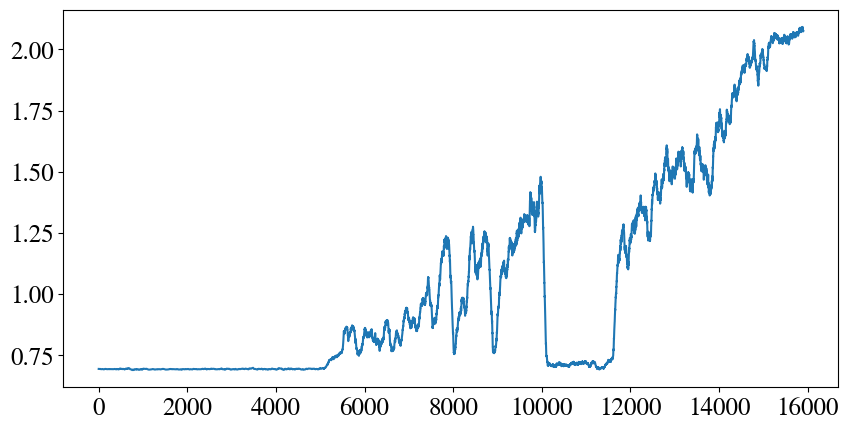

In [16]:
plt.plot(moving_average(G_losses, 100))

## Evaluate

In [17]:
datatest_con = get_simu_data(ntest, d, rho=0.9, is_homo=True, is_condition=True);
tX_con = torch.tensor(datatest_con.X)
tZ = torch.randn(ntest, nz);

In [18]:
netG.eval()
with torch.no_grad():
    tY_con_hat = netG(tX_con, tZ).detach().numpy().reshape(-1);
tY_con_hat.sum()

794.1597885489562

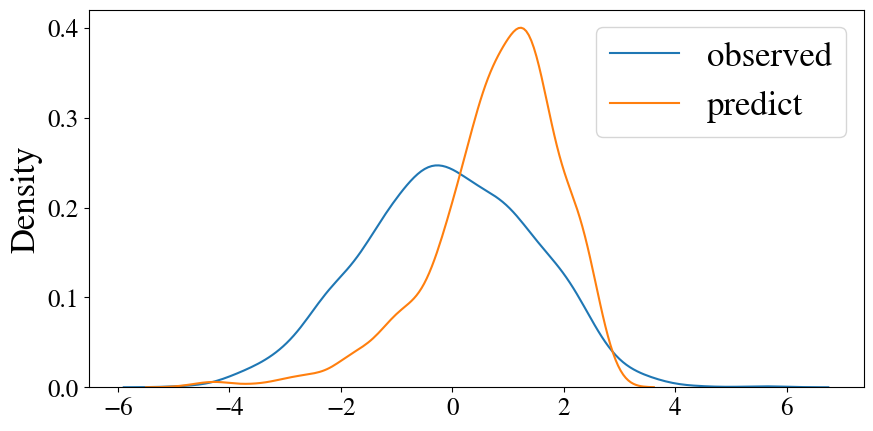

In [19]:
sns.kdeplot(datatest_con.Y1, label="observed")
sns.kdeplot(tY_con_hat, label="predict")
plt.legend()

(-10.0, 10.0)

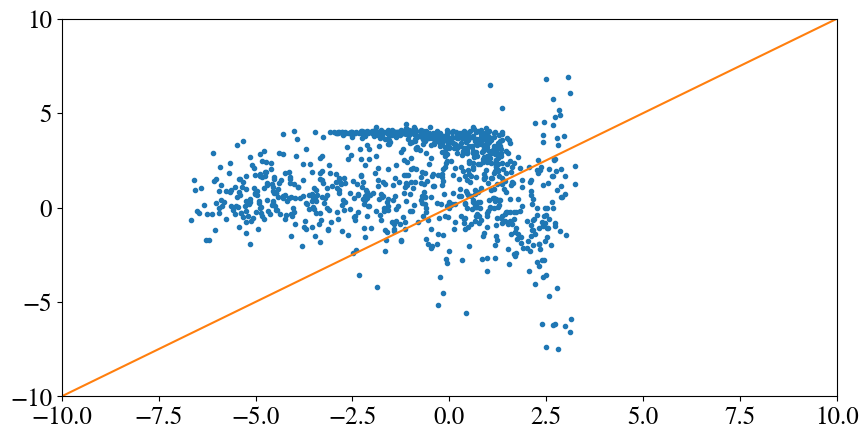

In [20]:
tX = torch.tensor(datatest.X)
tZ = torch.randn(ntest, nz);
netG.eval()
with torch.no_grad():
    tY_hat = netG(tX, tZ).detach().numpy().reshape(-1);
plt.figure(figsize=[10, 5])
plt.plot(tY_hat, datatest.Y1, ".")

xx = np.linspace(-10, 10, 100)
yy = xx
plt.plot(xx, yy)
plt.xlim([-10, 10])
plt.ylim([-10, 10])